In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import mutual_info_regression
import warnings

warnings.filterwarnings("ignore")

In [21]:
# Load the dataset
data = pd.read_csv('Housing.csv')

## 1. EDA

In [22]:
#Extracting all variable names
data.columns.tolist()

['price',
 'area',
 'bedrooms',
 'bathrooms',
 'stories',
 'mainroad',
 'guestroom',
 'basement',
 'hotwaterheating',
 'airconditioning',
 'parking',
 'prefarea',
 'furnishingstatus']

In [23]:
data

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2.0,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3.0,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2.0,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3.0,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2.0,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2.0,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0.0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0.0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0.0,no,furnished


In [24]:
# Preview the data
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             545 non-null    int64  
 1   area              545 non-null    int64  
 2   bedrooms          545 non-null    int64  
 3   bathrooms         545 non-null    int64  
 4   stories           545 non-null    int64  
 5   mainroad          543 non-null    object 
 6   guestroom         545 non-null    object 
 7   basement          545 non-null    object 
 8   hotwaterheating   543 non-null    object 
 9   airconditioning   545 non-null    object 
 10  parking           540 non-null    float64
 11  prefarea          544 non-null    object 
 12  furnishingstatus  545 non-null    object 
dtypes: float64(1), int64(5), object(7)
memory usage: 55.5+ KB


In [25]:
# Missing value analysis
data.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            2
guestroom           0
basement            0
hotwaterheating     2
airconditioning     0
parking             5
prefarea            1
furnishingstatus    0
dtype: int64

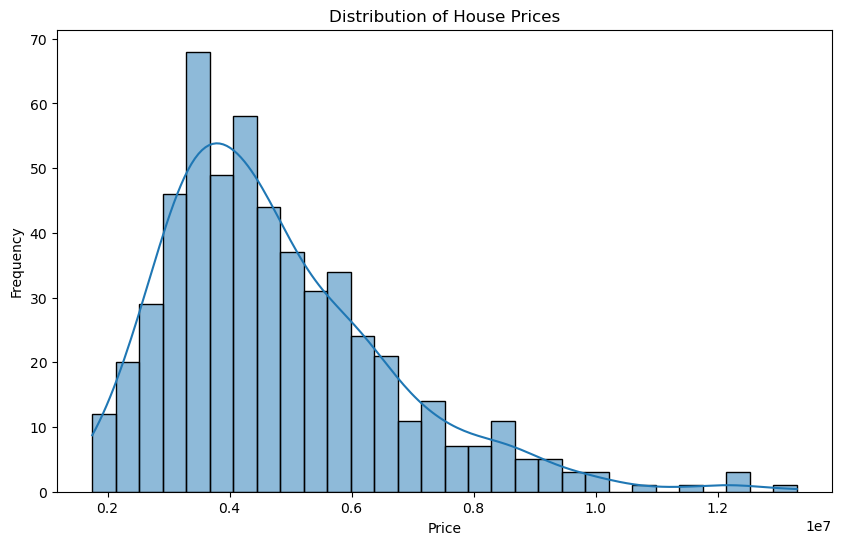

In [26]:
# Price distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['price'], bins=30, kde=True)
plt.title('Distribution of House Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

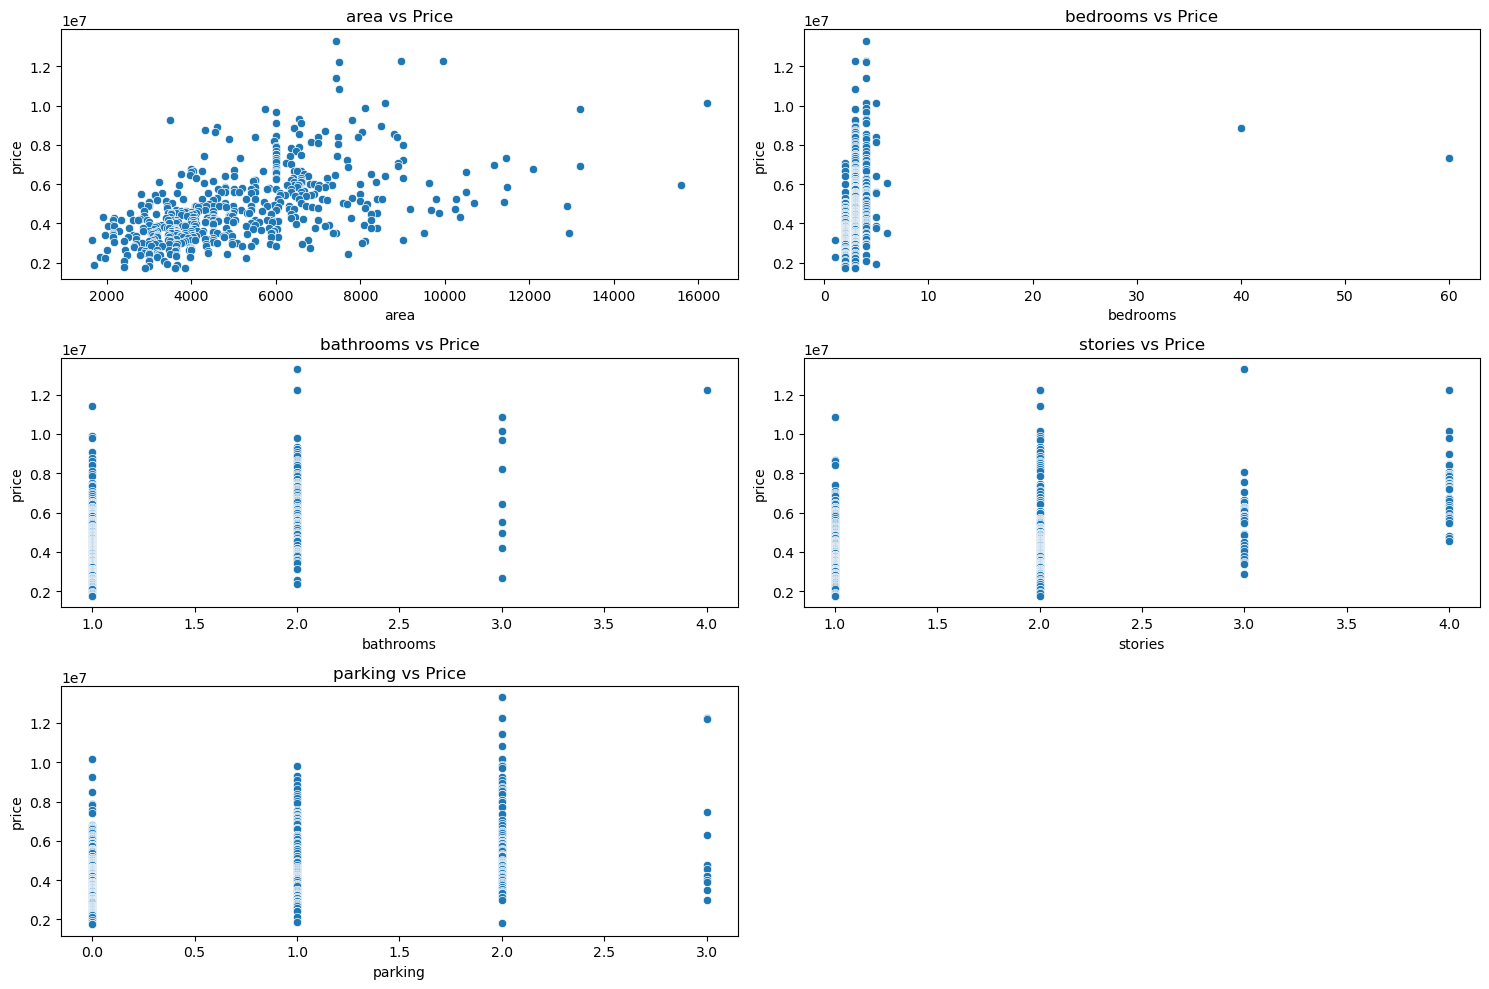

In [27]:

plt.figure(figsize=(15, 10))
# List of numerical features
numerical_features = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
# Plot each feature
for i, feature in enumerate(numerical_features, 1): 
    plt.subplot(3, 2, i)
    sns.scatterplot(x=data[feature], y=data['price'])
    plt.title(f'{feature} vs Price')
plt.tight_layout()
plt.show()

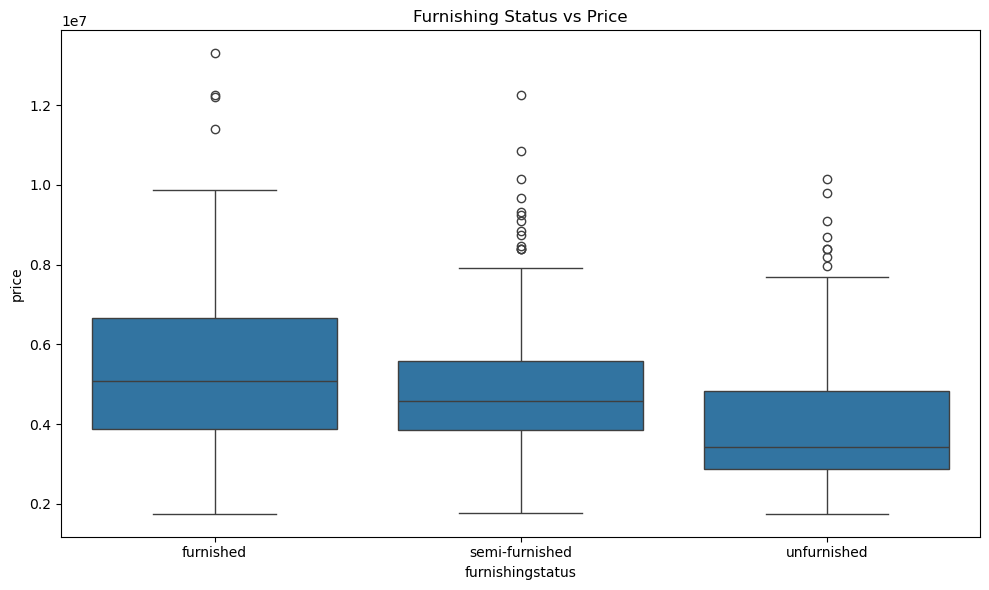

In [28]:
# Furnishing status vs Price
plt.figure(figsize=(10, 6))

# Plot the boxplot
sns.boxplot(x='furnishingstatus', y='price', data=data)
plt.title('Furnishing Status vs Price')
plt.tight_layout()
plt.show()

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             545 non-null    int64  
 1   area              545 non-null    int64  
 2   bedrooms          545 non-null    int64  
 3   bathrooms         545 non-null    int64  
 4   stories           545 non-null    int64  
 5   mainroad          543 non-null    object 
 6   guestroom         545 non-null    object 
 7   basement          545 non-null    object 
 8   hotwaterheating   543 non-null    object 
 9   airconditioning   545 non-null    object 
 10  parking           540 non-null    float64
 11  prefarea          544 non-null    object 
 12  furnishingstatus  545 non-null    object 
dtypes: float64(1), int64(5), object(7)
memory usage: 55.5+ KB


# 2. Data Cleaning & Preprocessing

## 2.1 Data Cleaning

In [30]:
# Handle extreme values in bedrooms
data = data[data['bedrooms'] <= 10]
data = data[data['area'] <= 10000]

### handling missing values

In [31]:
# Fill missing values
data['parking'].fillna(data['parking'].median(), inplace=True)
categorical_columns_missing = ['mainroad', 'hotwaterheating', 'prefarea']
for col in categorical_columns_missing:
    data[col].fillna(data[col].mode()[0], inplace=True)

### feature engineering

In [32]:
# Interaction terms
data['area_x_stories'] = data['area'] * data['stories']
data['bed_bath_ratio'] = data['bedrooms'] / (data['bathrooms'] + 1)

### encoding non-numerical variables

In [33]:
# Label Encoding
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 
               'airconditioning', 'prefarea']
data[binary_cols] = data[binary_cols].apply(lambda x: x.map({'yes': 1, 'no': 0}))

# One-hot encode 'furnishingstatus'
data = pd.get_dummies(data, columns=['furnishingstatus'], prefix='furnish', dtype=int)

### creating new varibles

In [34]:
# Create new features
data['price_per_area'] = data['price'] / data['area']
data['total_rooms'] = data['bedrooms'] + data['bathrooms']
data['luxury_score'] = data['airconditioning'] + data['hotwaterheating'] + data['prefarea']

### handling outliers

In [ ]:
# Winsorization for price and area
def winsorize(series, lower=0.05, upper=0.95):
    lower_bound = series.quantile(lower)
    upper_bound = series.quantile(upper)
    return series.clip(lower_bound, upper_bound)

data['price'] = winsorize(data['price'])
data['area'] = winsorize(data['area'])

### handling skewed data

In [36]:
# Power Transformation for Skewed Features
pt = PowerTransformer()
skewed_features = ['price', 'area', 'bedrooms', 'bathrooms', 'parking']
data[skewed_features] = pt.fit_transform(data[skewed_features])

## 2.2 Preprocessing

In [ ]:
# Feature Selection using Mutual Information
X_temp = data.drop('price', axis=1)
y_temp = data['price']

# Verify all columns are numeric
print("Data types before MI:")
print(X_temp.dtypes)

# Calculate Mutual Information
mi = mutual_info_regression(X_temp, y_temp)
mi_series = pd.Series(mi, index=X_temp.columns)
selected_features = mi_series[mi_series > 0.01].index.tolist()
selected_features.append('price')

data = data[selected_features]


Data types before MI:
area                      float64
bedrooms                  float64
bathrooms                 float64
stories                     int64
mainroad                    int64
guestroom                   int64
basement                    int64
airconditioning             int64
parking                   float64
prefarea                    int64
area_x_stories              int64
bed_bath_ratio            float64
furnish_furnished           int32
furnish_semi-furnished      int32
furnish_unfurnished         int32
price_per_area            float64
total_rooms                 int64
luxury_score                int64
dtype: object


### preparing fo modeling

In [40]:
# Prepare data for modeling
X = data.drop('price', axis=1)
y = data['price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Model Building

In [43]:
# 8. Hyperparameter Tuning Setup (Fixed)
def create_model(learning_rate=0.001, neurons=128, dropout_rate=0.2, activation='relu'):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train_scaled.shape[1], activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(neurons//2, activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate/2))
    
    model.add(Dense(neurons//4, activation=activation))
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

## Training

In [44]:
# Manually implement hyperparameter tuning
import itertools
from sklearn.model_selection import KFold
from tqdm import tqdm

# Define hyperparameter combinations
param_grid = {
    'learning_rate': [0.001, 0.0005, 0.0001],
    'neurons': [128, 256],
    'dropout_rate': [0.2, 0.3],
    'batch_size': [32, 64],
    'activation': ['relu', 'elu']
}

# Generate all combinations
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

# K-Fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)
best_score = -np.inf
best_params = None
best_model = None

for params in tqdm(param_combinations, desc="Hyperparameter Tuning"):
    fold_scores = []
    
    for train_index, val_index in kf.split(X_train_scaled):
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        
        model = create_model(
            learning_rate=params['learning_rate'],
            neurons=params['neurons'],
            dropout_rate=params['dropout_rate'],
            activation=params['activation']
        )
        
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        
        history = model.fit(
            X_train_fold, y_train_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=200,
            batch_size=params['batch_size'],
            callbacks=[early_stop],
            verbose=0
        )
        
        y_val_pred = model.predict(X_val_fold).flatten()
        r2 = r2_score(y_val_fold, y_val_pred)
        fold_scores.append(r2)
    
    mean_r2 = np.mean(fold_scores)
    
    if mean_r2 > best_score:
        best_score = mean_r2
        best_params = params
        best_model = model

print("="*50)
print(f"Best Parameters: {best_params}")
print(f"Best Validation R²: {best_score:.4f}")
print("="*50)

Hyperparameter Tuning:   0%|          | 0/48 [00:00<?, ?it/s]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000133019BC9A0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Hyperparameter Tuning:   2%|▏         | 1/48 [00:46<36:24, 46.49s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Hyperparameter Tuning:   4%|▍         | 2/48 [01:31<35:10, 45.88s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Hyperparameter Tuning:   6%|▋         | 3/48 [02:44<43:27, 57.93s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Hyperparameter Tuning:   8%|▊         | 4/48 [03:38<41:20, 56.37s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Hyperparameter Tuning:  10%|█         | 5/48 [04:57<46:22, 64.70s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Hyperparameter Tuning:  12%|█▎        | 6/48 [05:53<43:13, 61.76s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Hyperparameter Tuning:  15%|█▍        | 7/48 [07:10<45:31, 66.62s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Hyperparameter Tuning:  17%|█▋        | 8/48 [08:01<41:09, 61.73s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Hyperparameter Tuning:  19%|█▉        | 9/48 [08:55<38:32, 59.29s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Hyperparameter Tuning:  21%|██        | 10/48 [09:44<35:30, 56.08s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Hyperparameter Tuning:  23%|██▎       | 11/48 [10:44<35:23, 57.40s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Hyperparameter Tuning:  25%|██▌       | 12/48 [11:20<30:27, 50.75s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Hyperparameter Tuning:  27%|██▋       | 13/48 [12:05<28:41, 49.20s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Hyperparameter Tuning:  29%|██▉       | 14/48 [12:45<26:09, 46.16s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Hyperparameter Tuning:  31%|███▏      | 15/48 [13:54<29:18, 53.28s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Hyperparameter Tuning:  33%|███▎      | 16/48 [14:53<29:12, 54.76s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Hyperparameter Tuning:  35%|███▌      | 17/48 [15:58<29:55, 57.91s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Hyperparameter Tuning:  38%|███▊      | 18/48 [16:45<27:21, 54.72s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Hyperparameter Tuning:  40%|███▉      | 19/48 [17:59<29:15, 60.54s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Hyperparameter Tuning:  42%|████▏     | 20/48 [18:53<27:21, 58.64s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Hyperparameter Tuning:  44%|████▍     | 21/48 [20:06<28:14, 62.77s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Hyperparameter Tuning:  46%|████▌     | 22/48 [20:45<24:07, 55.66s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Hyperparameter Tuning:  48%|████▊     | 23/48 [22:14<27:21, 65.66s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Hyperparameter Tuning:  50%|█████     | 24/48 [23:18<26:03, 65.15s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Hyperparameter Tuning:  52%|█████▏    | 25/48 [23:56<21:52, 57.08s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Hyperparameter Tuning:  54%|█████▍    | 26/48 [24:40<19:27, 53.05s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Hyperparameter Tuning:  56%|█████▋    | 27/48 [25:38<19:07, 54.65s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Hyperparameter Tuning:  58%|█████▊    | 28/48 [26:24<17:21, 52.06s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Hyperparameter Tuning:  60%|██████    | 29/48 [27:15<16:23, 51.79s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Hyperparameter Tuning:  62%|██████▎   | 30/48 [28:05<15:21, 51.20s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Hyperparameter Tuning:  65%|██████▍   | 31/48 [28:51<14:00, 49.47s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Hyperparameter Tuning:  67%|██████▋   | 32/48 [29:43<13:26, 50.43s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Hyperparameter Tuning:  69%|██████▉   | 33/48 [31:49<18:16, 73.12s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Hyperparameter Tuning:  71%|███████   | 34/48 [33:18<18:09, 77.86s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Hyperparameter Tuning:  73%|███████▎  | 35/48 [35:03<18:36, 85.90s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Hyperparameter Tuning:  75%|███████▌  | 36/48 [36:28<17:06, 85.52s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Hyperparameter Tuning:  77%|███████▋  | 37/48 [37:57<15:53, 86.67s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Hyperparameter Tuning:  79%|███████▉  | 38/48 [38:58<13:10, 79.05s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Hyperparameter Tuning:  81%|████████▏ | 39/48 [40:20<11:58, 79.87s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Hyperparameter Tuning:  83%|████████▎ | 40/48 [41:19<09:49, 73.74s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Hyperparameter Tuning:  85%|████████▌ | 41/48 [42:18<08:04, 69.26s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Hyperparameter Tuning:  88%|████████▊ | 42/48 [43:06<06:17, 62.95s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Hyperparameter Tuning:  90%|████████▉ | 43/48 [44:18<05:27, 65.52s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Hyperparameter Tuning:  92%|█████████▏| 44/48 [45:18<04:15, 63.92s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Hyperparameter Tuning:  94%|█████████▍| 45/48 [46:14<03:04, 61.45s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Hyperparameter Tuning:  96%|█████████▌| 46/48 [46:53<01:49, 54.75s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Hyperparameter Tuning:  98%|█████████▊| 47/48 [48:16<01:03, 63.30s/it]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Hyperparameter Tuning: 100%|██████████| 48/48 [49:20<00:00, 61.68s/it]

Best Parameters: {'learning_rate': 0.001, 'neurons': 128, 'dropout_rate': 0.2, 'batch_size': 32, 'activation': 'elu'}
Best Validation R²: 0.9567


In [45]:
# 9. Final Model Training with Best Parameters
model = create_model(
    learning_rate=best_params['learning_rate'],
    neurons=best_params['neurons'],
    dropout_rate=best_params['dropout_rate'],
    activation=best_params['activation']
)

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=best_params['batch_size'],
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 1.2290 - mae: 0.8772 - val_loss: 0.4667 - val_mae: 0.5535
Epoch 2/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7206 - mae: 0.6804 - val_loss: 0.2752 - val_mae: 0.4258
Epoch 3/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4515 - mae: 0.5150 - val_loss: 0.2829 - val_mae: 0.4389
Epoch 4/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3267 - mae: 0.4492 - val_loss: 0.1971 - val_mae: 0.3568
Epoch 5/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3020 - mae: 0.4372 - val_loss: 0.2528 - val_mae: 0.4056
Epoch 6/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2560 - mae: 0.4108 - val_loss: 0.1514 - val_mae: 0.3143
Epoch 7/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2436 - mae: 0.3852 - val_loss: 0.1706 - val_mae: 0.3239
Epoch 8/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1890 - mae: 0.3544 - val_loss: 0.1912 - val_mae: 0.3448
Epoch 9/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - lo

## 5. Model Evaluation

In [46]:
# 10. Model Evaluation
y_pred = model.predict(X_test_scaled).flatten()

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("="*50)
print("Final Model Evaluation")
print("="*50)
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")
print("="*50)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Final Model Evaluation
MAE  : 0.1496
MSE  : 0.0424
RMSE : 0.2059
R²   : 0.9632


## 6. Visualizations

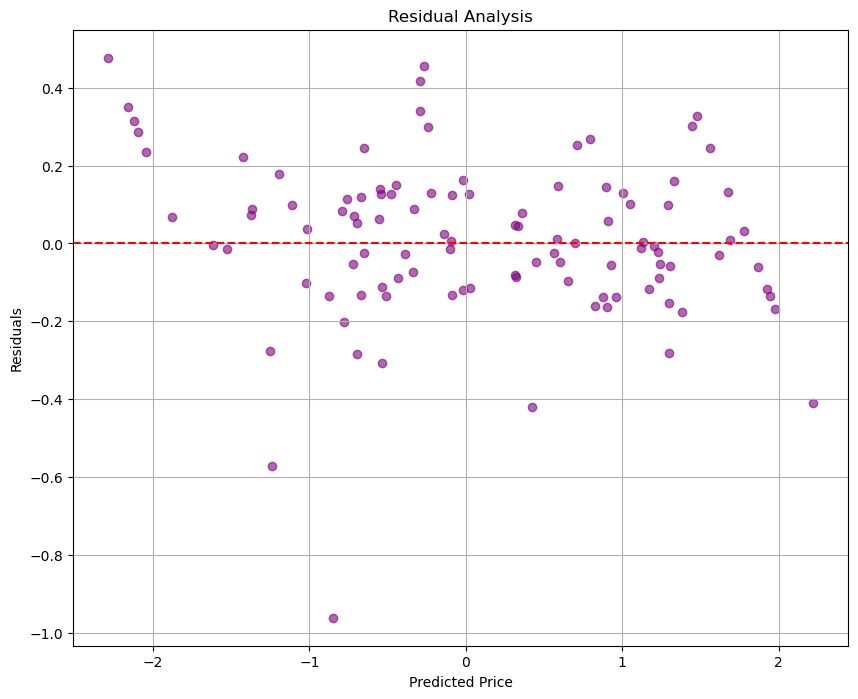

In [47]:
# 11. Visualization of Results
# Residual analysis
residuals = y_test - y_pred

plt.figure(figsize=(10, 8))
plt.scatter(y_pred, residuals, alpha=0.6, color='purple')
plt.axhline(0, linestyle='--', color='red')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.grid(True)
plt.show()

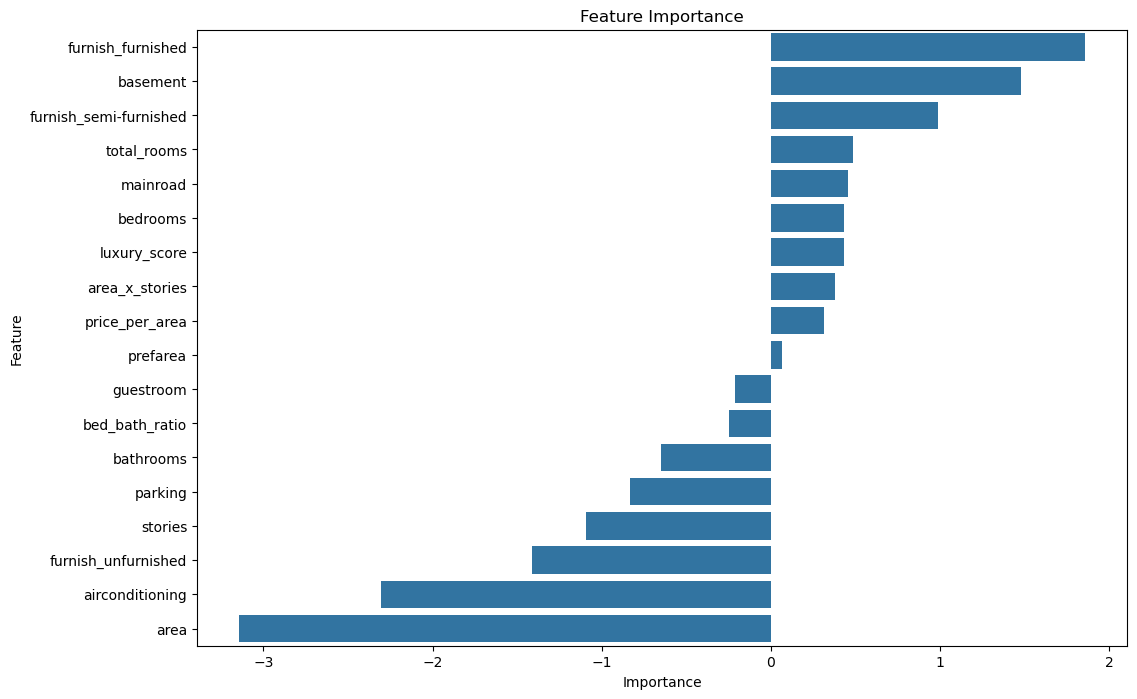

In [48]:
# Feature importance
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.layers[0].get_weights()[0].sum(axis=1)
})
coefficients = coefficients.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=coefficients)
plt.title('Feature Importance')
plt.show()

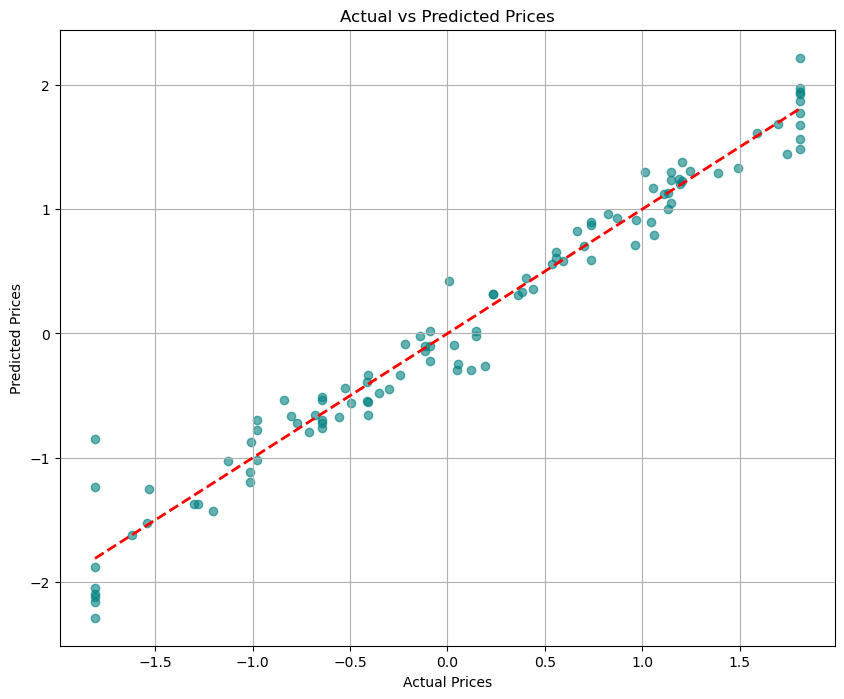

In [49]:
# Actual vs Predicted
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.6, color='teal')
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.grid(True)
plt.show()

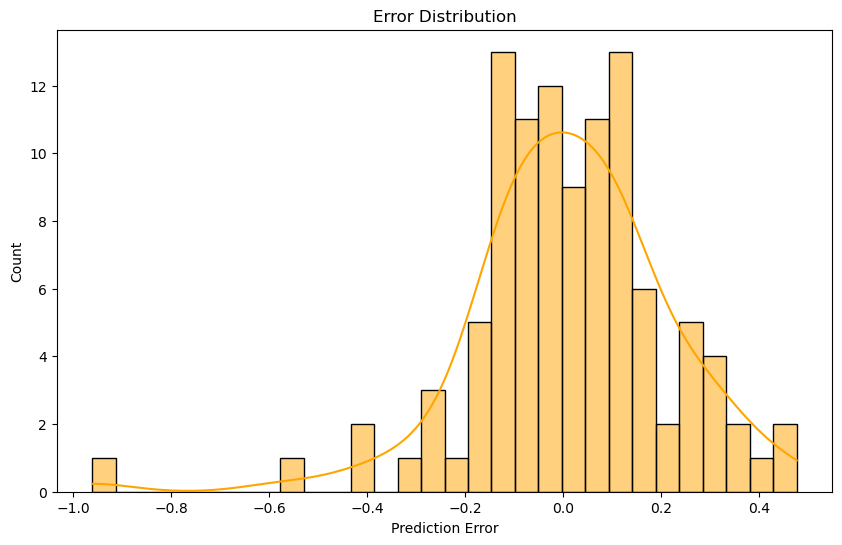

In [50]:
# Error distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='orange', bins=30)
plt.title('Error Distribution')
plt.xlabel('Prediction Error')
plt.show()

In [51]:
# 8. Base Model Training
def create_model():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Create model
model = create_model()

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [52]:
# Train model
print("Training base model...")
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Training base model...
Epoch 1/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.0890 - mae: 1.1234 - val_loss: 0.6798 - val_mae: 0.6775
Epoch 2/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0620 - mae: 0.7844 - val_loss: 0.5526 - val_mae: 0.6060
Epoch 3/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7163 - mae: 0.6450 - val_loss: 0.5876 - val_mae: 0.6262
Epoch 4/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5913 - mae: 0.6099 - val_loss: 0.6190 - val_mae: 0.6473
Epoch 5/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4697 - mae: 0.5418 - val_loss: 0.5902 - val_mae: 0.6323
Epoch 6/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5153 - mae: 0.5549 - val_loss: 0.5496 - val_mae: 0.6071
Epoch 7/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4110 - mae: 0.5194 - val_loss: 0.5264 - val_mae: 0.5914
Epoch 8/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3843 - mae: 0.4945 - val_loss: 0.4739 - val_mae: 0.5587
Epoch 9/300
11/11 ━━━━━━━━━━━━━━━

In [53]:
# 9. Model Evaluation
y_pred = model.predict(X_test_scaled).flatten()

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("="*50)
print("Base Model Evaluation")
print("="*50)
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")
print("="*50)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Base Model Evaluation
MAE  : 0.1705
MSE  : 0.0508
RMSE : 0.2254
R²   : 0.9559


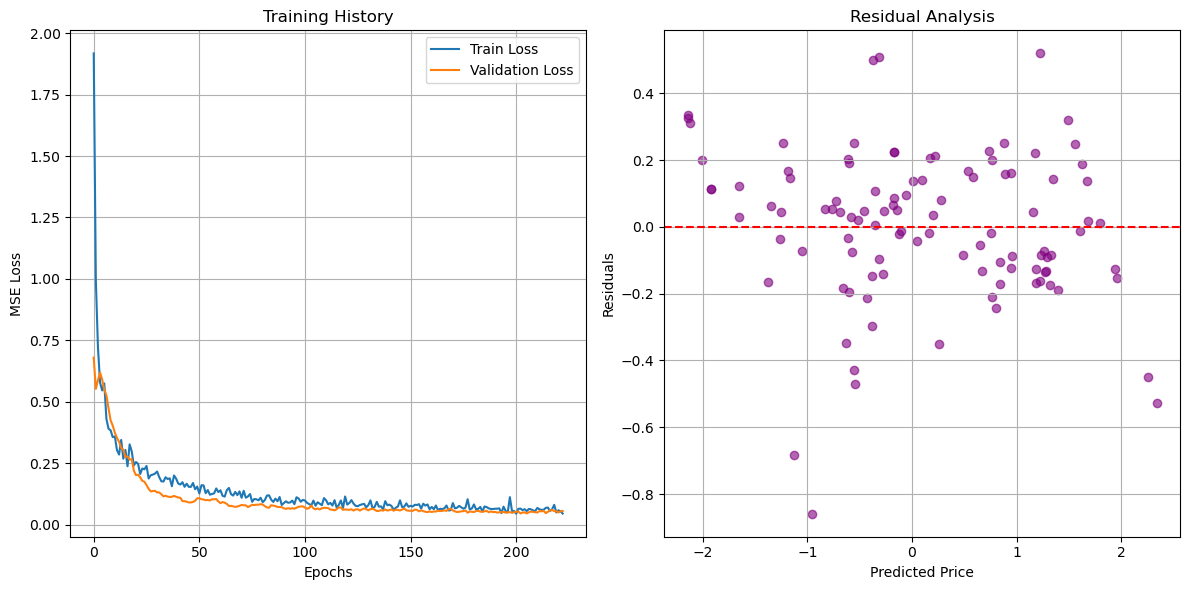

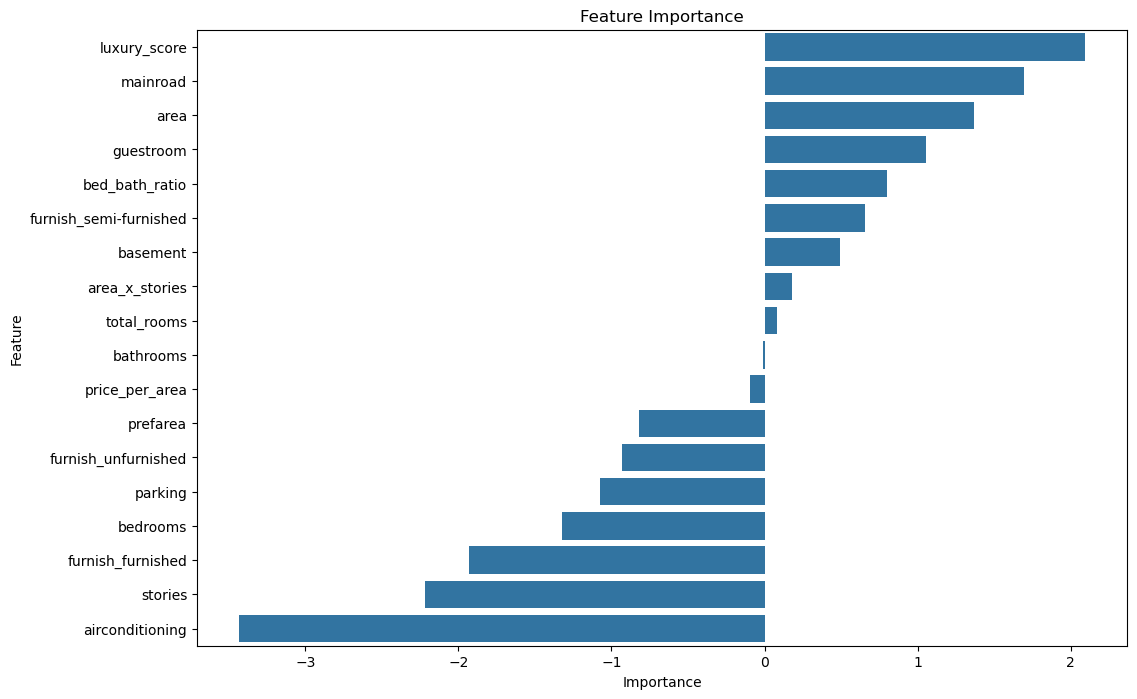

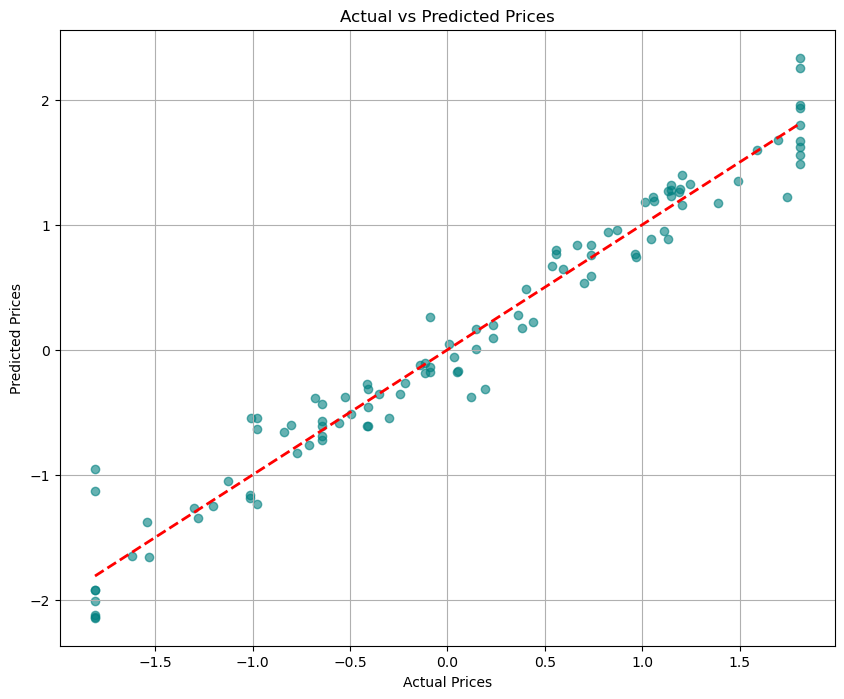

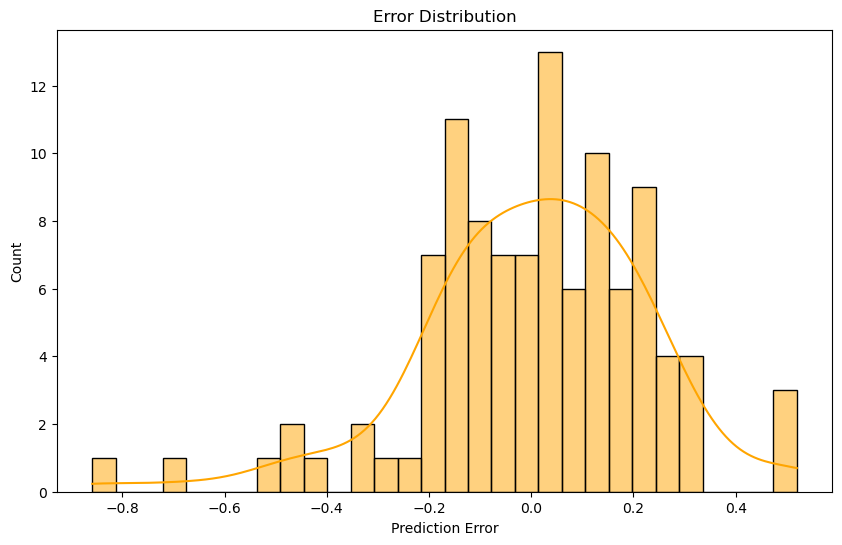

Model saved as housing_price_model.h5


In [54]:
# 10. Visualization of Results
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

# Residual analysis
residuals = y_test - y_pred
plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, alpha=0.6, color='purple')
plt.axhline(0, linestyle='--', color='red')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature importance
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.layers[0].get_weights()[0].sum(axis=1)
})
coefficients = coefficients.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=coefficients)
plt.title('Feature Importance')
plt.show()

# Actual vs Predicted
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.6, color='teal')
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.grid(True)
plt.show()

# Error distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='orange', bins=30)
plt.title('Error Distribution')
plt.xlabel('Prediction Error')
plt.show()

# Save model for future use
model.save('housing_price_model.h5')
print("Model saved as housing_price_model.h5")